<h2>Module 1 (Pose detection)</h2>

This module detect those images have full pose shots of humans.


<h2>Pose Detection with HRNet</h2>

This Module was developed using an open source project [lxy5513/hrnet](https://github.com/lxy5513/hrnet) to detect/track multi person poses.

In [ ]:
#impor libaries and git repos 

import os
import shutil
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/lxy5513/hrnet.git'
project_name = splitext(basename(git_repo_url))[0]
!pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
!cd {project_name}/lib && make
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
  !cd {project_name}/lib && make
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'tools'))
sys.path.append(join(project_name, 'lib'))
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

<h3>Downloading the Pre-Trained models coco and Yolov3</h3>

In [ ]:
#copy required weights, pre-trained models
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  

pretrained_model_parent_directory = 'models/pytorch/pose_coco'
pretrained_model_path = join(project_name, pretrained_model_parent_directory, 'pose_hrnet_w48_256x192.pth')
if not exists(pretrained_model_path):
  # download the pretrained model
  !rm -rf {project_name}/models
  !mkdir -p {project_name}/{pretrained_model_parent_directory}
  download_from_google_drive('15T2XqPjW7Ex0uyC1miGVYUv7ULOxIyJI', pretrained_model_path)
  
yolo_pretrained_model_path = join(project_name, 'lib/detector/yolo/yolov3.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  !cd {project_name}/lib/detector/yolo/ && wget -q https://pjreddie.com/media/files/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2292      0 --:--:-- --:--:-- --:--:--  2292
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  243M    0  243M    0     0  55.3M      0 --:--:--  0:00:04 --:--:-- 97.8M


<h3>Loading the hrnet and Yolo model</h3>

In [ ]:
import cv2
import numpy as np
from utilitys import plot_keypoint, PreProcess
from lib.core.inference import get_final_preds
import torch
import config
import models
from config import cfg, update_config
from types import SimpleNamespace
from google.colab.patches import cv2_imshow

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model


update_config(cfg,SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))

#function to load the model
def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model
  
#calling the function with updated configuration
pose_model = model_load(cfg).cuda()#HrNet model


human_model = yolo_model()#YOLO V3 model

Loading network.....
Network successfully loaded


<h3>Detect full pose image</h3>

In [ ]:
#function to detect full pose image

def detect_pose(pa,c):

  image = pa
  frame = cv2.imread(image, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
  bboxs, scores = yolo_det(frame, human_model)
  src_dir = pa 
  if len(bboxs)>0:
    inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)

    with torch.no_grad():
      # compute output heatmap
      inputs = inputs[:,[2,1,0]]
      output = pose_model(inputs.cuda())
      
      # compute coordinate
      preds, maxvals = get_final_preds(
          cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))
      thresh = 0.7
      if maxvals[0][0]>thresh and maxvals[0][1]>thresh and maxvals[0][2]>thresh and maxvals[0][3]>thresh and maxvals[0][4]>thresh and maxvals[0][13]>thresh and maxvals[0][14]>thresh and maxvals[0][15]>thresh and maxvals[0][16]>thresh:
        #dst_dir = '/content/full_shot' + '/' + f'image_{c}' + '.jpg' -- want to move all full shot to single folder
        #shutil.copy(src_dir,dst_dir)
        return 1
      else:
        return 0
        
  else:
    return 0

In [ ]:
# list of sample images
li=['image0_5.jpg','image0_6.jpg','image_1.jpg','image_4.jpg','image_5.jpg','image_6.jpg']

image0_5.jpg
Full Pose Image


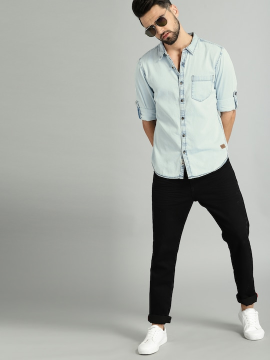



image0_6.jpg
Full Pose Image


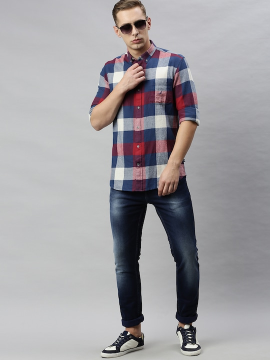



image_1.jpg
Not a Full Pose Image


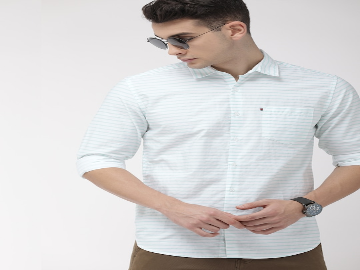



image_4.jpg
Not a Full Pose Image


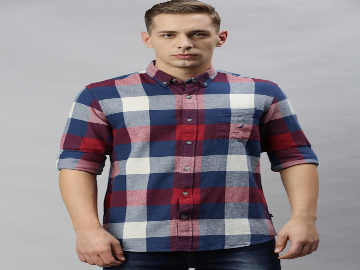



image_5.jpg
Not a Full Pose Image


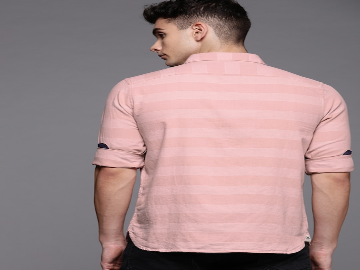



image_6.jpg
Full Pose Image


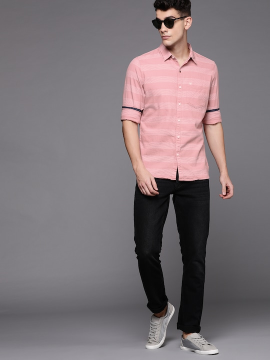

In [ ]:
#loop to detect the pose
for i in li:
  print('='*50)
  print(i)
  
  a = detect_pose(i,0)
  if a==1:
    print("Full Pose Image")
    frame = cv2.imread(i, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    frame = cv2.resize(frame,(270,360))
    cv2_imshow(frame)
    print('='*50)
    print('\n')
  if a==0:
    print("Not a Full Pose Image")
    frame = cv2.imread(i, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    frame = cv2.resize(frame,(360,270))
    cv2_imshow(frame)
    print('='*50)
    print('\n')

Image that are detected as full pose images will be passed to second object localization module training. Will be using HrNet as 
final model because it is giving good results on our dataset.